In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import joblib
from datetime import datetime
import os
import sys

# Scikit-learn components
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Create directories
os.makedirs('artifacts/all_best_models', exist_ok=True)

print("✅ All libraries imported successfully!")
print(f"Python version: {sys.version}")

✅ All libraries imported successfully!
Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]


In [2]:
# Load and prepare dataset
def load_dataset(csv_path="Train Data.csv"):
    """
    Load dataset from CSV file instead of hardcoded dictionary.
    Ensure the CSV column names match EXACTLY as used in your project.
    """
    df = pd.read_csv(csv_path)

    # Optional: Clean column names (remove spaces, unify formatting)
    df.columns = df.columns.str.strip()

    return df


# Load dataset
df = load_dataset("Train Data.csv")
print("📊 Dataset loaded successfully!")
print(f"Shape: {df.shape}")

# Display basic info
print("\n🔍 Dataset Info:")
print(df.info())

print("\n📈 First 5 rows:")
df.head()

📊 Dataset loaded successfully!
Shape: (463, 11)

🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               463 non-null    object 
 1   Signal Strength (dBm)   463 non-null    float64
 2   SNR                     463 non-null    float64
 3   Call Duration (s)       463 non-null    float64
 4   Environment             463 non-null    object 
 5   Attenuation             463 non-null    float64
 6   Distance to Tower (km)  463 non-null    float64
 7   Tower ID                463 non-null    int64  
 8   User ID                 463 non-null    int64  
 9   Call Type               463 non-null    object 
 10  Incoming/Outgoing       463 non-null    object 
dtypes: float64(5), int64(2), object(4)
memory usage: 39.9+ KB
None

📈 First 5 rows:


,Timestamp,Signal Strength (dBm),SNR,Call Duration (s),Environment,Attenuation,Distance to Tower (km),Tower ID,User ID,Call Type,Incoming/Outgoing
0,01-03-2024 17:46,-84.119763,25.940082,1713.800550,urban,14.690438,2.243176,5,25,data,incoming
1,01-04-2024 17:29,-87.806131,15.937354,345.371848,home,6.213698,5.002567,3,22,voice,incoming
2,01-05-2024 17:14,-116.575176,14.709384,259.285043,open,4.494415,8.705974,2,5,voice,incoming
3,01-06-2024 16:02,-82.961183,21.727165,357.974004,home,7.619957,7.427025,5,33,data,outgoing
4,01-07-2024 22:19,-85.012574,26.058158,398.006716,urban,10.655159,0.612071,5,8,voice,outgoing


In [3]:
def clean_and_preprocess(df):
    """Comprehensive data cleaning and preprocessing"""
    df_clean = df.copy()

    # Parse timestamp (handle multiple formats)
    df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')

    # Drop irrelevant columns as specified
    columns_to_drop = ['Tower ID', 'User ID', 'Call Type', 'Incoming/Outgoing', 'Call Duration (s)']
    df_clean = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])

    # Handle missing values
    numeric_columns = ['Signal Strength (dBm)', 'SNR', 'Attenuation', 'Distance to Tower (km)']
    categorical_columns = ['Environment']

    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    for col in categorical_columns:
        if col in df_clean.columns:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

    # Outlier treatment using IQR (more robust)
    for col in numeric_columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Cap outliers
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

    # Ensure categorical columns are string type
    for col in categorical_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)

    return df_clean

df_clean = clean_and_preprocess(df)
print("✅ Data cleaning completed!")
print(f"Cleaned dataset shape: {df_clean.shape}")
print("\nCleaned dataset info:")
print(df_clean.info())
display(df_clean.head())

✅ Data cleaning completed!
Cleaned dataset shape: (463, 6)

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               187 non-null    datetime64[ns]
 1   Signal Strength (dBm)   463 non-null    float64       
 2   SNR                     463 non-null    float64       
 3   Environment             463 non-null    object        
 4   Attenuation             463 non-null    float64       
 5   Distance to Tower (km)  463 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 21.8+ KB
None


,Timestamp,Signal Strength (dBm),SNR,Environment,Attenuation,Distance to Tower (km)
0,2024-01-03 17:46:00,-84.119763,25.940082,urban,14.690438,2.243176
1,2024-01-04 17:29:00,-87.806131,15.937354,home,6.213698,5.002567
2,2024-01-05 17:14:00,-116.575176,14.709384,open,4.494415,8.705974
3,2024-01-06 16:02:00,-82.961183,21.727165,home,7.619957,7.427025
4,2024-01-07 22:19:00,-85.012574,26.058158,urban,10.655159,0.612071


In [4]:
# Constant transmitter power
P_tx_dBm = 23

# Calculate path loss
df_clean['path_loss'] = P_tx_dBm - df_clean['Signal Strength (dBm)']

print("✅ Path Loss calculated successfully!")
print(f"Path Loss Statistics:")
print(f"   Min: {df_clean['path_loss'].min():.2f} dB")
print(f"   Max: {df_clean['path_loss'].max():.2f} dB")
print(f"   Mean: {df_clean['path_loss'].mean():.2f} dB")
print(f"   Std: {df_clean['path_loss'].std():.2f} dB")

print("\nDataset with Path Loss:")
display(df_clean[['Signal Strength (dBm)', 'path_loss']].head())

✅ Path Loss calculated successfully!
Path Loss Statistics:
   Min: 73.12 dB
   Max: 141.68 dB
   Mean: 107.96 dB
   Std: 14.35 dB

Dataset with Path Loss:


,Signal Strength (dBm),path_loss
0,-84.119763,107.119763
1,-87.806131,110.806131
2,-116.575176,139.575176
3,-82.961183,105.961183
4,-85.012574,108.012574


In [5]:
def engineer_features(df):
    """Create advanced features for better model performance"""
    df_eng = df.copy()

    # Time-based features
    df_eng['hour'] = df_eng['Timestamp'].dt.hour
    df_eng['day_of_week'] = df_eng['Timestamp'].dt.dayofweek
    df_eng['day_of_month'] = df_eng['Timestamp'].dt.day

    # Cyclical encoding for time features
    df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng['hour'] / 24)
    df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng['hour'] / 24)
    df_eng['day_sin'] = np.sin(2 * np.pi * df_eng['day_of_week'] / 7)
    df_eng['day_cos'] = np.cos(2 * np.pi * df_eng['day_of_week'] / 7)

    # Distance transformations
    df_eng['log_distance'] = np.log1p(df_eng['Distance to Tower (km)'])
    df_eng['distance_squared'] = df_eng['Distance to Tower (km)'] ** 2
    df_eng['inverse_distance'] = 1 / (df_eng['Distance to Tower (km)'] + 0.1)

    # SNR transformations
    df_eng['log_snr'] = np.log1p(df_eng['SNR'])
    df_eng['snr_squared'] = df_eng['SNR'] ** 2

    # Attenuation transformations
    df_eng['log_attenuation'] = np.log1p(df_eng['Attenuation'])
    df_eng['attenuation_squared'] = df_eng['Attenuation'] ** 2

    # Environment encoding
    environment_quality = {'open': 0, 'suburban': 1, 'urban': 2, 'home': 1.5}
    df_eng['environment_quality'] = df_eng['Environment'].map(environment_quality)

    # Interaction features
    df_eng['distance_attenuation'] = df_eng['Distance to Tower (km)'] * df_eng['Attenuation']
    df_eng['snr_distance'] = df_eng['SNR'] * df_eng['Distance to Tower (km)']
    df_eng['signal_quality'] = df_eng['SNR'] / (df_eng['Distance to Tower (km)'] + 1)

    # Signal strength based features
    df_eng['effective_strength'] = df_eng['Signal Strength (dBm)'] * df_eng['SNR'] / 20

    print(f"✅ Feature engineering completed! Added {len([col for col in df_eng.columns if col not in df.columns])} new features")
    return df_eng

df_engineered = engineer_features(df_clean)
print(f"Original features: {len(df_clean.columns)}")
print(f"Engineered features: {len(df_engineered.columns)}")

# Show new features
new_features = [col for col in df_engineered.columns if col not in df_clean.columns]
print(f"New features: {new_features}")
display(df_engineered[new_features].head())

✅ Feature engineering completed! Added 19 new features
Original features: 7
Engineered features: 26
New features: ['hour', 'day_of_week', 'day_of_month', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'log_distance', 'distance_squared', 'inverse_distance', 'log_snr', 'snr_squared', 'log_attenuation', 'attenuation_squared', 'environment_quality', 'distance_attenuation', 'snr_distance', 'signal_quality', 'effective_strength']


,hour,day_of_week,day_of_month,hour_sin,hour_cos,day_sin,day_cos,log_distance,distance_squared,inverse_distance,log_snr,snr_squared,log_attenuation,attenuation_squared,environment_quality,distance_attenuation,snr_distance,signal_quality,effective_strength
0,17.0,2.0,3.0,-0.965926,-0.258819,0.974928,-0.222521,1.176553,5.031840,0.426771,3.293615,672.887845,2.753051,215.808958,2.0,32.953242,58.188178,7.998357,-109.103677
1,17.0,3.0,4.0,-0.965926,-0.258819,0.433884,-0.900969,1.792187,25.025672,0.195980,2.829521,253.999252,1.975982,38.610044,1.5,31.084438,79.727673,2.655090,-69.969869
2,17.0,4.0,5.0,-0.965926,-0.258819,-0.433884,-0.900969,2.272742,75.793975,0.113559,2.754258,216.365986,1.703732,20.199766,0.0,39.128258,128.059510,1.515498,-85.737453
3,16.0,5.0,6.0,-0.866025,-0.500000,-0.974928,-0.222521,2.131444,55.160694,0.132855,3.123561,472.069703,2.154080,58.063752,1.5,56.593611,161.368189,2.578272,-90.125566
4,22.0,6.0,7.0,-0.500000,0.866025,-0.781831,0.623490,0.477519,0.374630,1.404355,3.297989,679.027621,2.455749,113.532410,2.0,6.521709,15.949430,16.164404,-110.763556


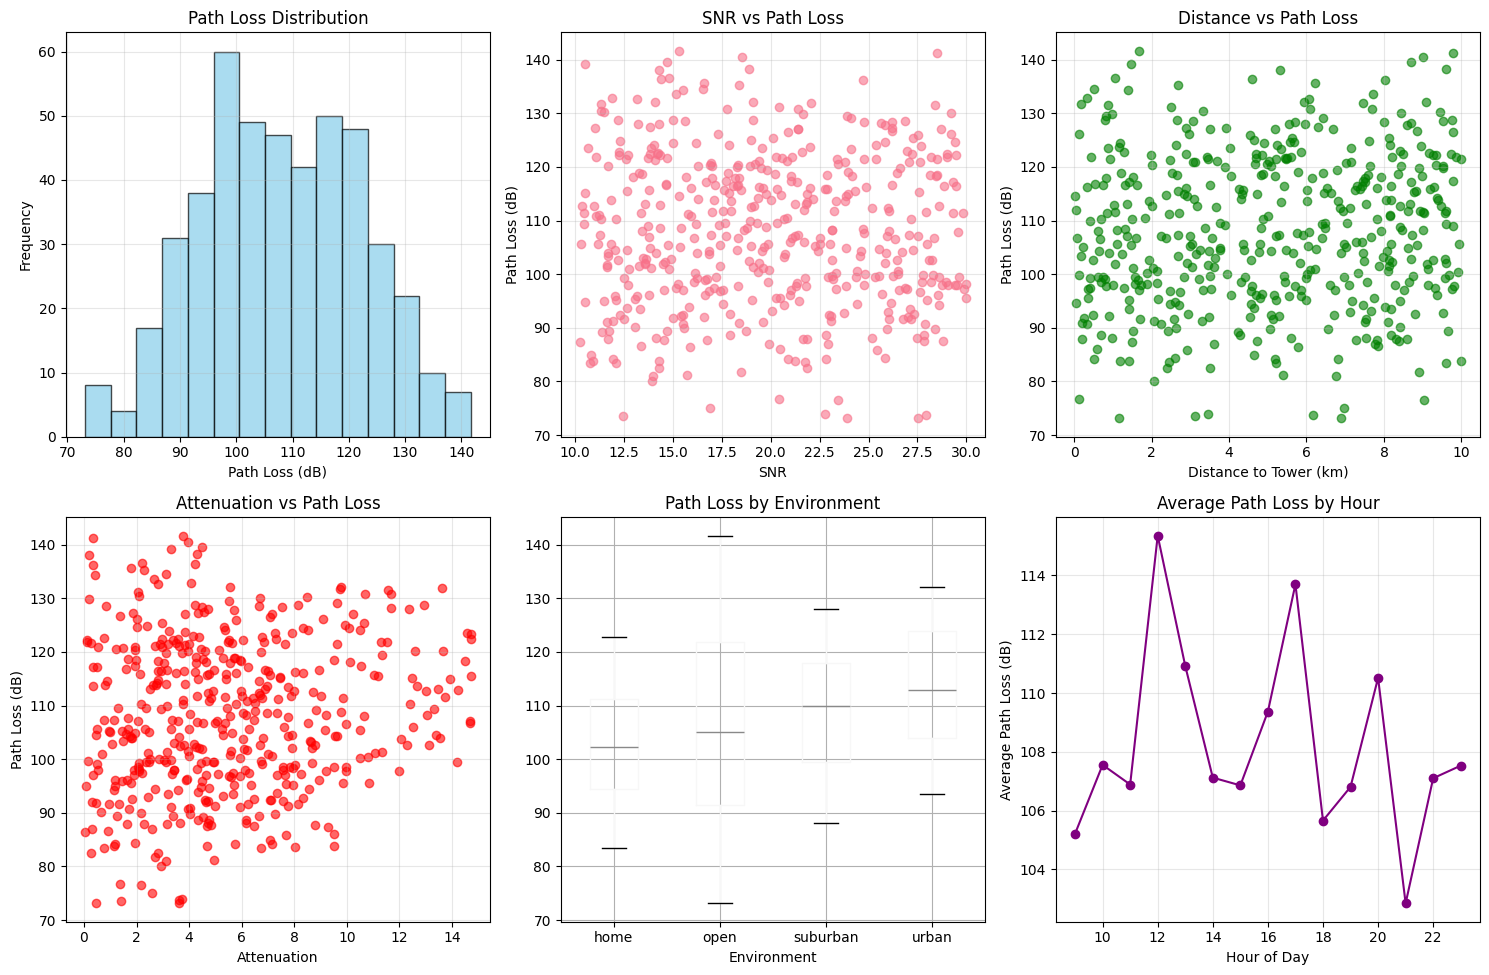

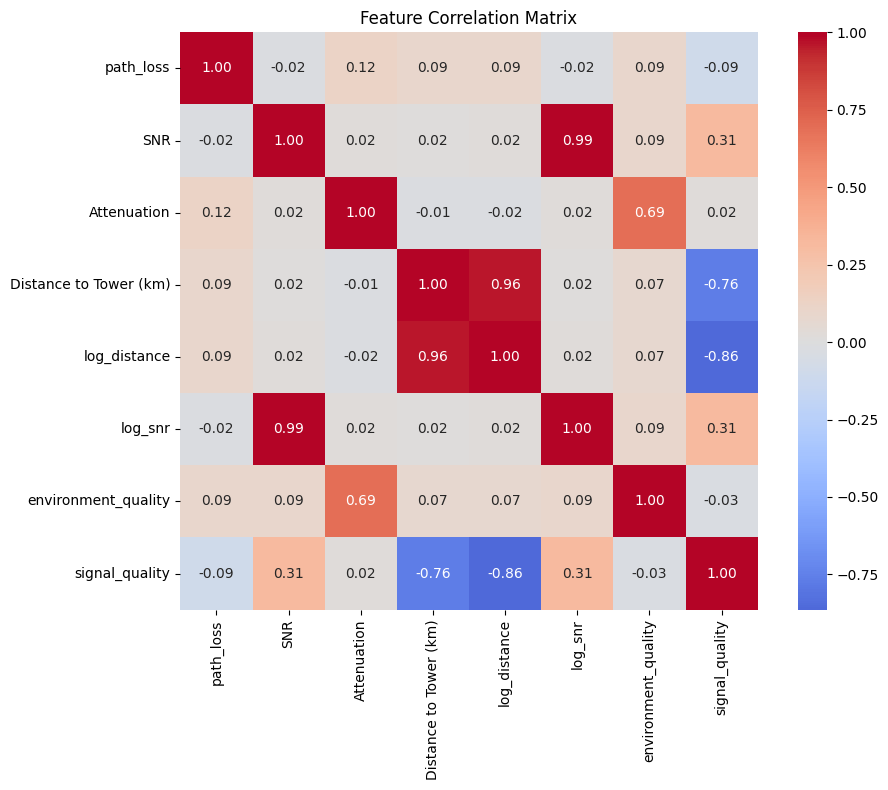

Correlation with Path Loss:
   Attenuation: 0.120
   Distance to Tower (km): 0.092
   environment_quality: 0.089
   log_distance: 0.086
   log_snr: -0.016
   SNR: -0.022
   signal_quality: -0.092


In [6]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Path Loss Distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df_engineered['path_loss'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Path Loss Distribution')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. SNR vs Path Loss
plt.subplot(2, 3, 2)
plt.scatter(df_engineered['SNR'], df_engineered['path_loss'], alpha=0.6)
plt.title('SNR vs Path Loss')
plt.xlabel('SNR')
plt.ylabel('Path Loss (dB)')
plt.grid(True, alpha=0.3)

# 3. Distance vs Path Loss
plt.subplot(2, 3, 3)
plt.scatter(df_engineered['Distance to Tower (km)'], df_engineered['path_loss'], alpha=0.6, color='green')
plt.title('Distance vs Path Loss')
plt.xlabel('Distance to Tower (km)')
plt.ylabel('Path Loss (dB)')
plt.grid(True, alpha=0.3)

# 4. Attenuation vs Path Loss
plt.subplot(2, 3, 4)
plt.scatter(df_engineered['Attenuation'], df_engineered['path_loss'], alpha=0.6, color='red')
plt.title('Attenuation vs Path Loss')
plt.xlabel('Attenuation')
plt.ylabel('Path Loss (dB)')
plt.grid(True, alpha=0.3)

# 5. Environment vs Path Loss
plt.subplot(2, 3, 5)
df_engineered.boxplot(column='path_loss', by='Environment', ax=plt.gca())
plt.title('Path Loss by Environment')
plt.suptitle('')

# 6. Hour vs Path Loss
plt.subplot(2, 3, 6)
hourly_avg = df_engineered.groupby('hour')['path_loss'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='purple')
plt.title('Average Path Loss by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Path Loss (dB)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix
numeric_columns = ['path_loss', 'SNR', 'Attenuation', 'Distance to Tower (km)',
                  'log_distance', 'log_snr', 'environment_quality', 'signal_quality']
corr_matrix = df_engineered[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation with Path Loss:")
path_loss_corr = corr_matrix['path_loss'].sort_values(ascending=False)
for feature, corr_value in path_loss_corr.items():
    if feature != 'path_loss':
        print(f"   {feature}: {corr_value:.3f}")

In [7]:
# Select the most relevant features
selected_features = [
    # Original features
    'SNR', 'Attenuation', 'Distance to Tower (km)', 'Environment',

    # Engineered features
    'log_distance', 'log_snr', 'log_attenuation',
    'environment_quality', 'distance_attenuation', 'snr_distance',
    'signal_quality', 'hour_sin', 'hour_cos', 'effective_strength'
]

X = df_engineered[selected_features]
y = df_engineered['path_loss']

print(f"Selected {len(selected_features)} features for modeling")
print(f"Features: {selected_features}")

# Train/Validation/Test split with stratification for small dataset
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42  # 0.176 * 0.85 ≈ 0.15
)

print(f"Data splitting completed:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Selected 14 features for modeling
Features: ['SNR', 'Attenuation', 'Distance to Tower (km)', 'Environment', 'log_distance', 'log_snr', 'log_attenuation', 'environment_quality', 'distance_attenuation', 'snr_distance', 'signal_quality', 'hour_sin', 'hour_cos', 'effective_strength']
Data splitting completed:
Training set: 323 samples (69.8%)
Validation set: 70 samples (15.1%)
Test set: 70 samples (15.1%)


In [8]:
# Define categorical and numerical features
categorical_features = ['Environment']
numerical_features = [col for col in selected_features if col not in categorical_features]

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# Create robust preprocessing pipeline with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Fit and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert to dense arrays if sparse and ensure no NaN values
def ensure_dense_and_clean(X):
    """Convert to dense array and handle any remaining NaN values"""
    if hasattr(X, 'toarray'):
        X_dense = X.toarray()
    else:
        X_dense = X.copy()

    # Replace any remaining NaN values with 0
    X_dense = np.nan_to_num(X_dense, nan=0.0)
    return X_dense

X_train_processed = ensure_dense_and_clean(X_train_processed)
X_val_processed = ensure_dense_and_clean(X_val_processed)
X_test_processed = ensure_dense_and_clean(X_test_processed)

print(f"Preprocessing completed successfully!")
print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed validation set shape: {X_val_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

# Verify no NaN values
print(f"NaN values in processed data:")
print(f"  X_train: {np.isnan(X_train_processed).sum()}")
print(f"  X_val: {np.isnan(X_val_processed).sum()}")
print(f"  X_test: {np.isnan(X_test_processed).sum()}")

Categorical features: ['Environment']
Numerical features: ['SNR', 'Attenuation', 'Distance to Tower (km)', 'log_distance', 'log_snr', 'log_attenuation', 'environment_quality', 'distance_attenuation', 'snr_distance', 'signal_quality', 'hour_sin', 'hour_cos', 'effective_strength']
Preprocessing completed successfully!
Processed training set shape: (323, 16)
Processed validation set shape: (70, 16)
Processed test set shape: (70, 16)
NaN values in processed data:
  X_train: 0
  X_val: 0
  X_test: 0


In [9]:
# Define all models with optimized parameters
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'LASSO Regression': {
        'model': Lasso(random_state=42),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'max_iter': [1000, 2000]
        }
    },
    'Elastic Net': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.5, 0.9],
            'max_iter': [1000, 2000]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, verbosity=0),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9, -1],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'epsilon': [0.01, 0.1]
        }
    }
}

# Train and tune models with robust error handling
best_models = {}
results = []

print("Starting model training and hyperparameter tuning...")

for model_name, model_config in models.items():
    print(f"\nTraining {model_name}...")

    try:
        # For small dataset, use simpler approach
        if len(X_train_processed) < 50:  # Very small dataset
            print("Small dataset detected, using direct fitting...")
            model = model_config['model']

            # Handle models that might have issues with small data
            if model_name in ['SVR', 'LASSO', 'Elastic Net']:
                # Use default parameters for small data
                model.fit(X_train_processed, y_train)
            else:
                model.fit(X_train_processed, y_train)

            val_pred = model.predict(X_val_processed)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            best_models[model_name] = model

        elif not model_config['params']:
            # Models with no hyperparameters
            model = model_config['model']
            model.fit(X_train_processed, y_train)
            val_pred = model.predict(X_val_processed)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            best_models[model_name] = model
        else:
            # Randomized Search CV
            random_search = RandomizedSearchCV(
                estimator=model_config['model'],
                param_distributions=model_config['params'],
                n_iter=10,
                cv=min(3, len(X_train_processed)),  # Adaptive CV folds
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                random_state=42,
                verbose=0
            )

            random_search.fit(X_train_processed, y_train)
            best_models[model_name] = random_search.best_estimator_
            val_rmse = -random_search.best_score_

        # Calculate validation metrics
        val_pred = best_models[model_name].predict(X_val_processed)
        val_mae = mean_absolute_error(y_val, val_pred)
        val_r2 = r2_score(y_val, val_pred)

        results.append({
            'Model': model_name,
            'Validation_RMSE': val_rmse,
            'Validation_MAE': val_mae,
            'Validation_R2': val_r2
        })

        # Save model
        model_filename = f'artifacts/all_best_models/{model_name.replace(" ", "_").lower()}.joblib'
        joblib.dump(best_models[model_name], model_filename)

        print(f"✅ {model_name} - Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}, Val R²: {val_r2:.4f}")

    except Exception as e:
        print(f"❌ Error training {model_name}: {str(e)[:100]}...")
        results.append({
            'Model': model_name,
            'Validation_RMSE': np.inf,
            'Validation_MAE': np.inf,
            'Validation_R2': -np.inf
        })

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results).sort_values('Validation_RMSE')
print("\nModel Performance Ranking:")
display(results_df)

# Save preprocessor
joblib.dump(preprocessor, 'artifacts/preprocessor.joblib')
print("Preprocessor saved!")

Starting model training and hyperparameter tuning...

Training Linear Regression...
✅ Linear Regression - Val RMSE: 3.9627, Val MAE: 3.1023, Val R²: 0.9303

Training Ridge Regression...
✅ Ridge Regression - Val RMSE: 4.1458, Val MAE: 3.0929, Val R²: 0.9275

Training LASSO Regression...
✅ LASSO Regression - Val RMSE: 4.1139, Val MAE: 3.0663, Val R²: 0.9259

Training Elastic Net...
✅ Elastic Net - Val RMSE: 4.1218, Val MAE: 3.1025, Val R²: 0.9281

Training Random Forest...
✅ Random Forest - Val RMSE: 4.9042, Val MAE: 3.0267, Val R²: 0.9306

Training XGBoost...
✅ XGBoost - Val RMSE: 4.2532, Val MAE: 3.1839, Val R²: 0.9317

Training LightGBM...
✅ LightGBM - Val RMSE: 5.1711, Val MAE: 2.7727, Val R²: 0.9344

Training Gradient Boosting...
✅ Gradient Boosting - Val RMSE: 3.5246, Val MAE: 2.5474, Val R²: 0.9527

Training SVR...
✅ SVR - Val RMSE: 4.1905, Val MAE: 3.0675, Val R²: 0.9273

Model Performance Ranking:


,Model,Validation_RMSE,Validation_MAE,Validation_R2
7,Gradient Boosting,3.524607,2.547373,0.952664
0,Linear Regression,3.962719,3.102288,0.930286
2,LASSO Regression,4.113858,3.066266,0.925877
3,Elastic Net,4.121774,3.102457,0.928055
1,Ridge Regression,4.145781,3.092859,0.927463
8,SVR,4.190468,3.067465,0.927293
5,XGBoost,4.253228,3.183912,0.931712
4,Random Forest,4.904155,3.026712,0.930603
6,LightGBM,5.171096,2.772711,0.934372


Preprocessor saved!


In [10]:
# Evaluate all models on test set
final_results = []

print("Evaluating models on test set...")

for model_name, model in best_models.items():
    try:
        # Make predictions
        y_pred = model.predict(X_test_processed)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        final_results.append({
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R2_Score': r2
        })

        print(f"✅ {model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {e}")

# Convert to DataFrame and sort by RMSE
final_results_df = pd.DataFrame(final_results).sort_values('RMSE')
print("\nFinal Test Set Performance:")
display(final_results_df)

# Identify best model
best_model_name = final_results_df.iloc[0]['Model']
best_model = best_models[best_model_name]
best_model_metrics = final_results_df.iloc[0]

print(f"\nBest Model: {best_model_name}")
print(f"Best Model RMSE: {best_model_metrics['RMSE']:.4f}")
print(f"Best Model MAE: {best_model_metrics['MAE']:.4f}")
print(f"Best Model R²: {best_model_metrics['R2_Score']:.4f}")

Evaluating models on test set...
✅ Linear Regression - RMSE: 4.1541, MAE: 3.0586, R²: 0.9213
✅ Ridge Regression - RMSE: 4.0529, MAE: 2.9596, R²: 0.9250
✅ LASSO Regression - RMSE: 3.8569, MAE: 2.7463, R²: 0.9321
✅ Elastic Net - RMSE: 4.0080, MAE: 2.9024, R²: 0.9267
✅ Random Forest - RMSE: 3.5675, MAE: 2.6693, R²: 0.9419
✅ XGBoost - RMSE: 3.5301, MAE: 2.7048, R²: 0.9431
✅ LightGBM - RMSE: 3.7558, MAE: 2.9186, R²: 0.9356
✅ Gradient Boosting - RMSE: 2.9133, MAE: 2.1871, R²: 0.9613
✅ SVR - RMSE: 3.6990, MAE: 2.5965, R²: 0.9376

Final Test Set Performance:


,Model,RMSE,MAE,R2_Score
7,Gradient Boosting,2.913290,2.187063,0.961269
5,XGBoost,3.530126,2.704791,0.943132
4,Random Forest,3.567526,2.669285,0.941921
8,SVR,3.698992,2.596479,0.937561
6,LightGBM,3.755806,2.918628,0.935629
2,LASSO Regression,3.856902,2.746349,0.932117
3,Elastic Net,4.007968,2.902367,0.926695
1,Ridge Regression,4.052907,2.959562,0.925042
0,Linear Regression,4.154105,3.058577,0.921252



Best Model: Gradient Boosting
Best Model RMSE: 2.9133
Best Model MAE: 2.1871
Best Model R²: 0.9613


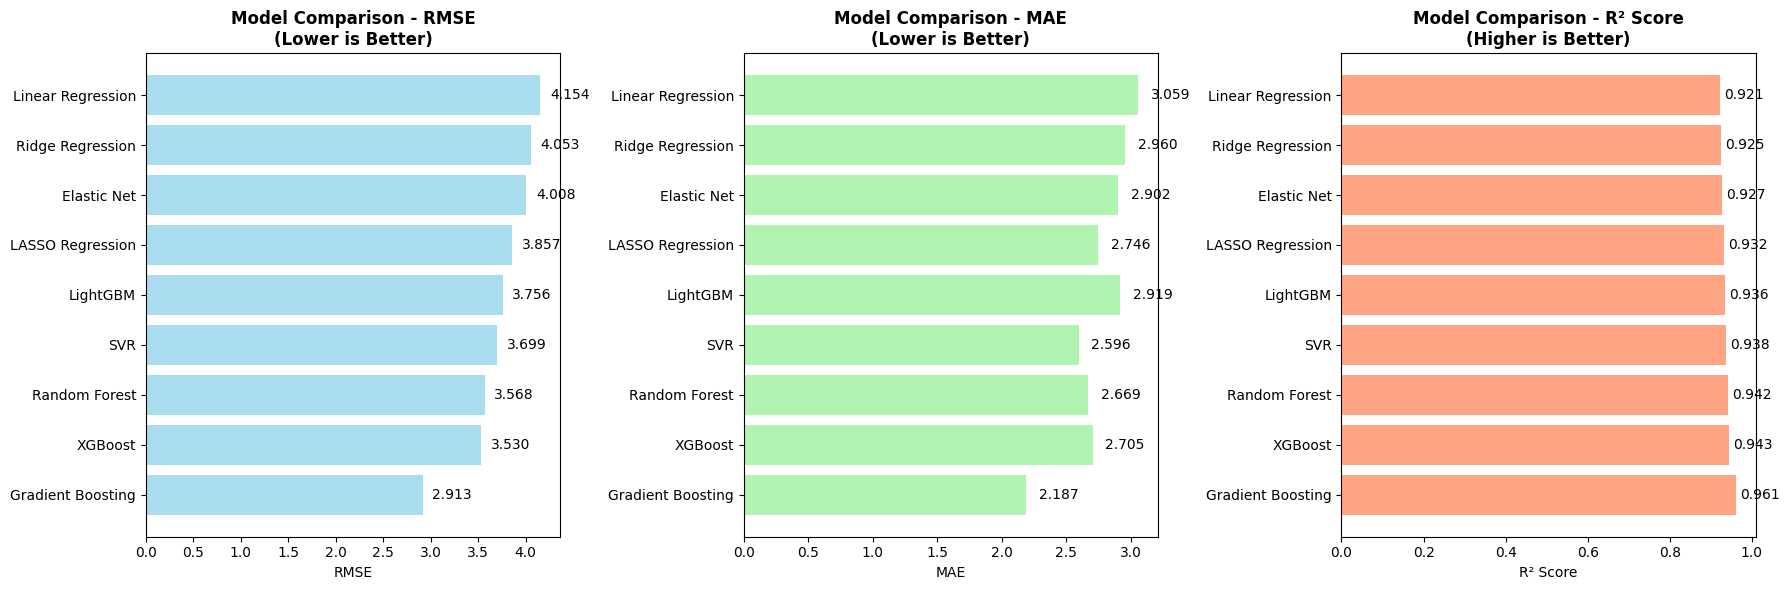

In [11]:
# Create performance comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Comparison
axes[0].barh(final_results_df['Model'], final_results_df['RMSE'], color='skyblue', alpha=0.7)
axes[0].set_title('Model Comparison - RMSE\n(Lower is Better)', fontweight='bold')
axes[0].set_xlabel('RMSE')
for i, v in enumerate(final_results_df['RMSE']):
    axes[0].text(v + 0.1, i, f'{v:.3f}', va='center')

# MAE Comparison
axes[1].barh(final_results_df['Model'], final_results_df['MAE'], color='lightgreen', alpha=0.7)
axes[1].set_title('Model Comparison - MAE\n(Lower is Better)', fontweight='bold')
axes[1].set_xlabel('MAE')
for i, v in enumerate(final_results_df['MAE']):
    axes[1].text(v + 0.1, i, f'{v:.3f}', va='center')

# R² Comparison
axes[2].barh(final_results_df['Model'], final_results_df['R2_Score'], color='coral', alpha=0.7)
axes[2].set_title('Model Comparison - R² Score\n(Higher is Better)', fontweight='bold')
axes[2].set_xlabel('R² Score')
for i, v in enumerate(final_results_df['R2_Score']):
    axes[2].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

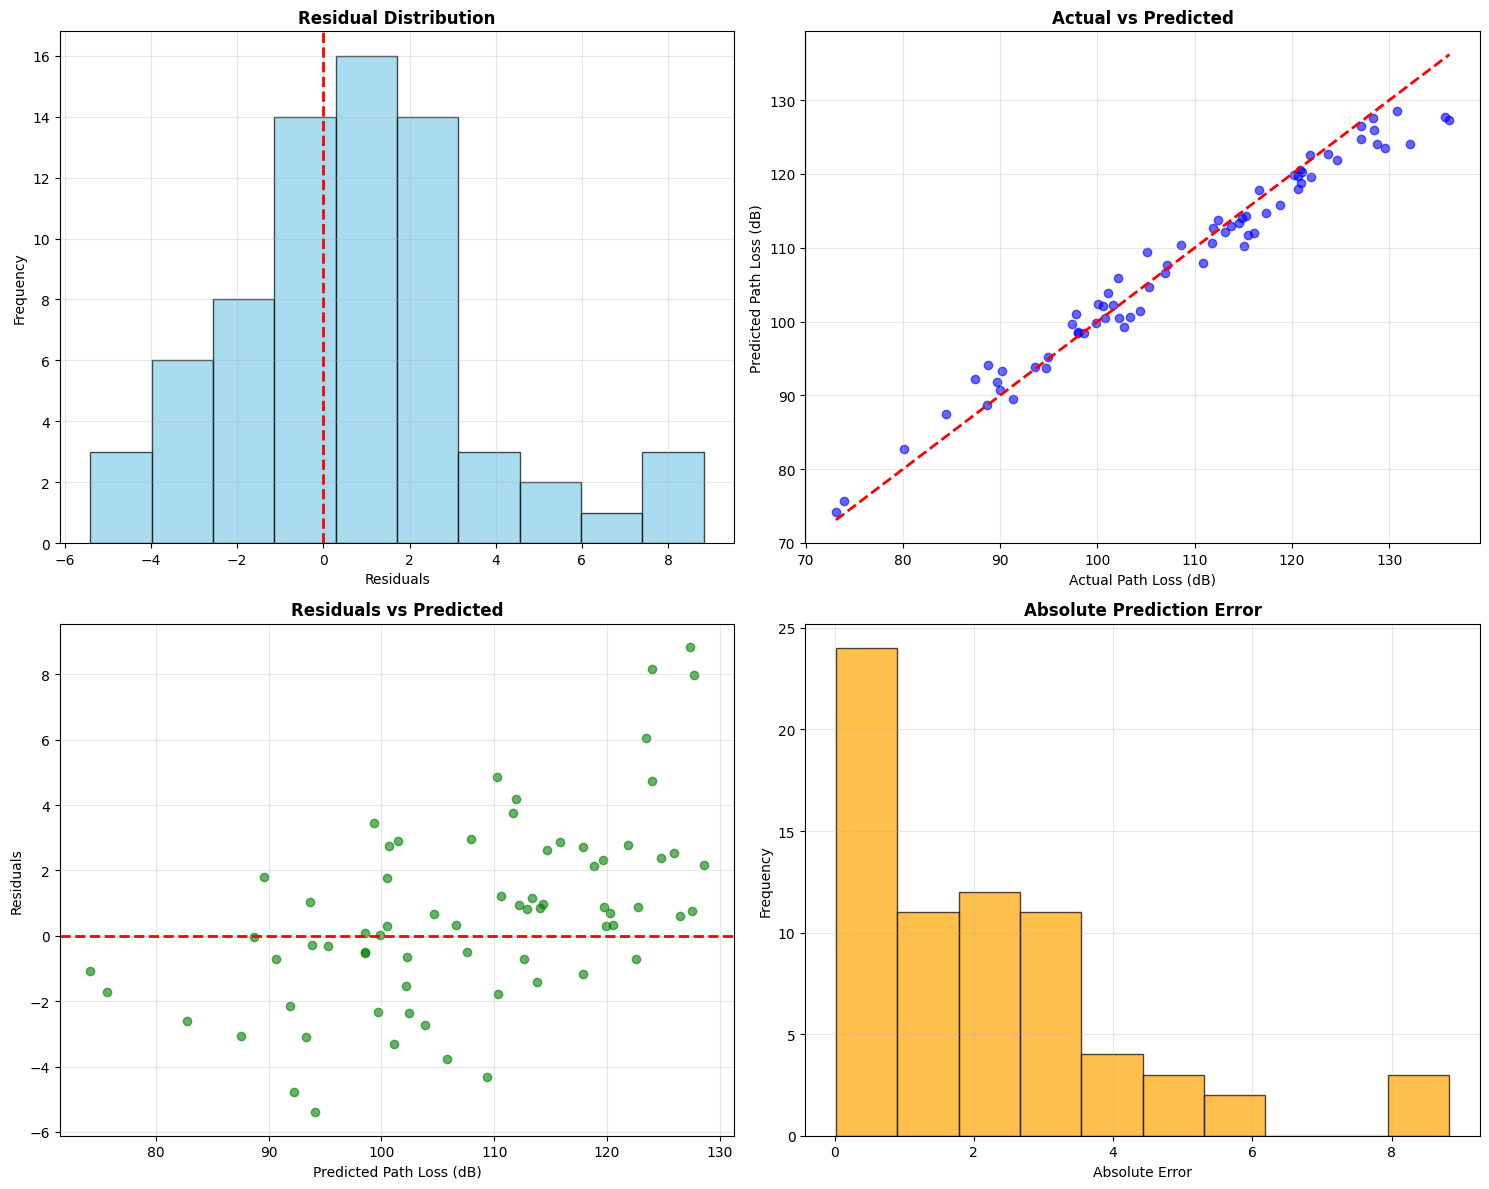

Error Analysis Statistics:
   Mean Residual: 0.6578
   Std of Residuals: 2.8585
   Mean Absolute Error: 2.1871
   Max Error: 8.8302


In [12]:
# Get predictions from best model
y_pred_best = best_model.predict(X_test_processed)
residuals = y_test - y_pred_best

# Create comprehensive error analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residual Distribution
axes[0, 0].hist(residuals, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residual Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Residuals')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted
axes[0, 1].scatter(y_test, y_pred_best, alpha=0.6, color='blue')
max_val = max(y_test.max(), y_pred_best.max())
min_val = min(y_test.min(), y_pred_best.min())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0, 1].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 1].set_xlabel('Actual Path Loss (dB)')
axes[0, 1].set_ylabel('Predicted Path Loss (dB)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals vs Predicted
axes[1, 0].scatter(y_pred_best, residuals, alpha=0.6, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuals vs Predicted', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Path Loss (dB)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Absolute Prediction Error
error = np.abs(residuals)
axes[1, 1].hist(error, bins=10, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Absolute Prediction Error', fontweight='bold')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error statistics
print("Error Analysis Statistics:")
print(f"   Mean Residual: {residuals.mean():.4f}")
print(f"   Std of Residuals: {residuals.std():.4f}")
print(f"   Mean Absolute Error: {error.mean():.4f}")
print(f"   Max Error: {error.max():.4f}")

In [13]:
# Save the best model
joblib.dump(best_model, 'artifacts/best_model.joblib')
print("Best model saved as 'artifacts/best_model.joblib'")

# Save feature info
feature_info = {
    'selected_features': selected_features,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features
}
joblib.dump(feature_info, 'artifacts/feature_info.joblib')
print("Feature information saved")

# Save final results
final_results_df.to_csv('artifacts/model_performance_results.csv', index=False)
print("Model performance results saved")

# Enhanced inference function
def predict_path_loss(input_data, model_path='artifacts/best_model.joblib',
                     preprocessor_path='artifacts/preprocessor.joblib',
                     feature_info_path='artifacts/feature_info.joblib'):
    """
    Predict path loss for new input data with robust error handling
    """
    try:
        # Load artifacts
        model = joblib.load(model_path)
        preprocessor = joblib.load(preprocessor_path)
        feature_info = joblib.load(feature_info_path)

        # Convert input to DataFrame
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        elif isinstance(input_data, list):
            input_df = pd.DataFrame(input_data)
        else:
            input_df = input_data.copy()

        # Ensure timestamp is parsed
        if 'Timestamp' in input_df.columns:
            input_df['Timestamp'] = pd.to_datetime(input_df['Timestamp'], errors='coerce')

        # Apply feature engineering
        input_df = engineer_features(input_df)

        # Select features and handle missing ones
        missing_features = set(feature_info['selected_features']) - set(input_df.columns)
        if missing_features:
            print(f"Warning: Missing features {missing_features}, filling with defaults")
            for feature in missing_features:
                if feature in feature_info['numerical_features']:
                    input_df[feature] = 0.0
                else:
                    input_df[feature] = 'missing'

        X_input = input_df[feature_info['selected_features']]

        # Preprocess and predict
        X_processed = preprocessor.transform(X_input)
        X_processed = ensure_dense_and_clean(X_processed)

        predictions = model.predict(X_processed)

        return predictions

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Test inference
print("Testing inference function...")
sample_input = {
    'Timestamp': '2024-01-25 14:30:00',
    'Signal Strength (dBm)': -85.0,
    'SNR': 20.5,
    'Environment': 'urban',
    'Attenuation': 8.2,
    'Distance to Tower (km)': 3.5
}

prediction = predict_path_loss(sample_input)
if prediction is not None:
    print(f"Sample prediction successful!")
    print(f"Input Signal Strength: {sample_input['Signal Strength (dBm)']} dBm")
    print(f"Predicted Path Loss: {prediction[0]:.2f} dB")
    print(f"Estimated RX Power: {23 - prediction[0]:.2f} dBm")

print(f"\nPROJECT SUMMARY:")
print(f"Best Model: {best_model_name}")
print(f"Test RMSE: {best_model_metrics['RMSE']:.4f} dB")
print(f"Test MAE: {best_model_metrics['MAE']:.4f} dB")
print(f"Test R²: {best_model_metrics['R2_Score']:.4f}")

Best model saved as 'artifacts/best_model.joblib'
Feature information saved
Model performance results saved
Testing inference function...
✅ Feature engineering completed! Added 19 new features
Sample prediction successful!
Input Signal Strength: -85.0 dBm
Predicted Path Loss: 106.56 dB
Estimated RX Power: -83.56 dBm

PROJECT SUMMARY:
Best Model: Gradient Boosting
Test RMSE: 2.9133 dB
Test MAE: 2.1871 dB
Test R²: 0.9613


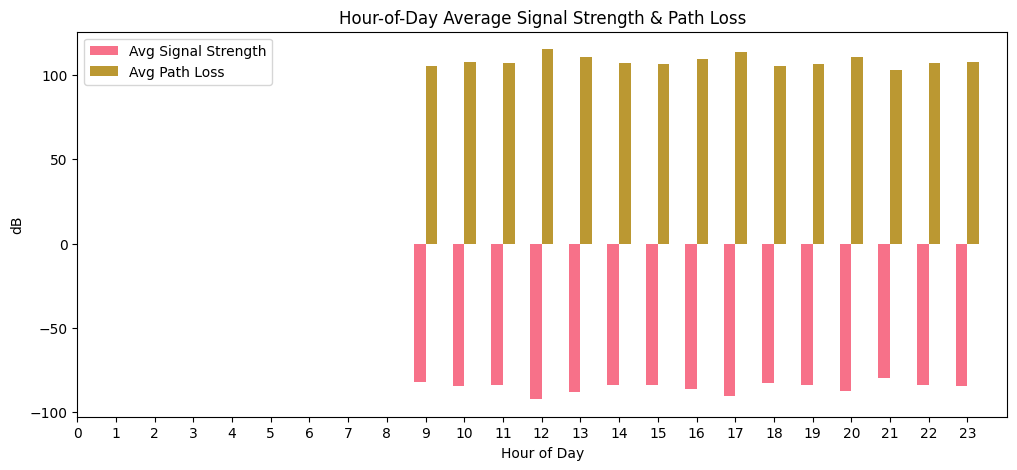

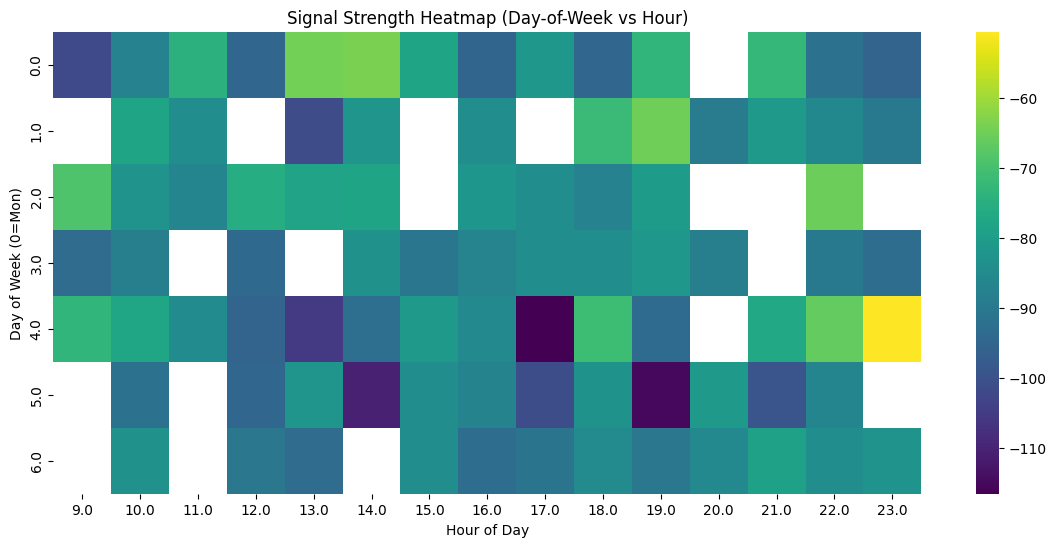

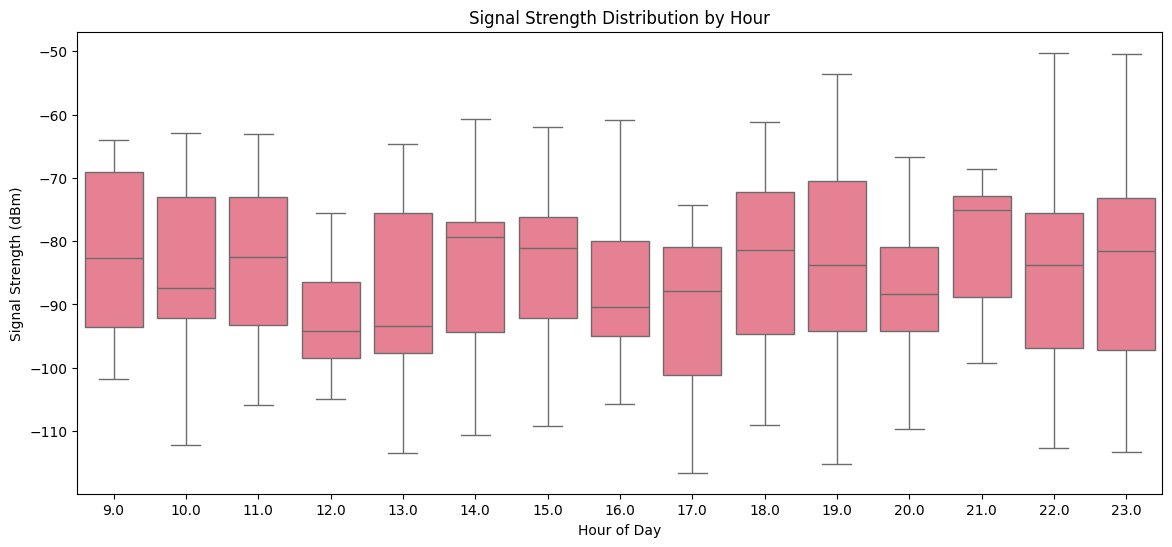

Time-based analysis complete: generated line, bar, heatmap, and boxplot visualizations.


In [14]:
# Ensure required data availability
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Choose the engineered DataFrame if available; fall back to raw df
_df = None
for cand in ['df_engineered', 'df_clean', 'df']:
    if cand in globals():
        _df = globals()[cand].copy()
        break

if _df is None:
    raise RuntimeError("No dataframe (df_engineered/df_clean/df) found for time-based analysis.")

# Confirm Timestamp dtype
if not np.issubdtype(_df['Timestamp'].dtype, np.datetime64):
    _df['Timestamp'] = pd.to_datetime(_df['Timestamp'])

# Derive path loss if missing
if 'Path Loss (dB)' not in _df.columns and 'Signal Strength (dBm)' in _df.columns:
    _df['Path Loss (dB)'] = P_tx_dBm - _df['Signal Strength (dBm)']

# Sort by time
_df = _df.sort_values('Timestamp')

# Optionally resample to reduce noise if very granular (< second level). We'll do hourly mean.
_df_hourly = _df.set_index('Timestamp').resample('H').agg({
    'Signal Strength (dBm)': 'mean',
    'Path Loss (dB)': 'mean'
}).rename(columns={'Signal Strength (dBm)': 'SignalStrengthMean', 'Path Loss (dB)': 'PathLossMean'})

# Hour-of-day aggregation
_df['hour'] = _df['Timestamp'].dt.hour
hourly_stats = _df.groupby('hour').agg({'Signal Strength (dBm)': 'mean', 'Path Loss (dB)': 'mean'}).reset_index()

# Day-of-week vs hour heatmap matrix
_df['day_of_week'] = _df['Timestamp'].dt.dayofweek
heat_matrix = _df.pivot_table(index='day_of_week', columns='hour', values='Signal Strength (dBm)', aggfunc='mean')

# Rolling window (12 samples or 12 hours depending on data density)
window = min(12, max(3, int(len(_df_hourly) / 10)))
_df_hourly['SignalStrengthRolling'] = _df_hourly['SignalStrengthMean'].rolling(window, min_periods=1).mean()
_df_hourly['PathLossRolling'] = _df_hourly['PathLossMean'].rolling(window, min_periods=1).mean()

# 1. Raw/Resampled Line Plot (Plotly)
fig_ts = px.line(
    _df_hourly.reset_index(),
    x='Timestamp',
    y=['SignalStrengthMean', 'PathLossMean', 'SignalStrengthRolling', 'PathLossRolling'],
    title='Hourly Mean Signal Strength & Path Loss (with Rolling Smoothing)',
    labels={'value': 'dB', 'Timestamp': 'Time'},
)
fig_ts.update_layout(legend_title_text='Metrics', height=500)
fig_ts.show()

# 2. Hour-of-Day Bar Chart
plt.figure(figsize=(12,5))
ax1 = plt.gca()
ax1.bar(hourly_stats['hour'] - 0.15, hourly_stats['Signal Strength (dBm)'], width=0.3, label='Avg Signal Strength')
ax1.bar(hourly_stats['hour'] + 0.15, hourly_stats['Path Loss (dB)'], width=0.3, label='Avg Path Loss')
ax1.set_xticks(range(0,24))
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('dB')
ax1.set_title('Hour-of-Day Average Signal Strength & Path Loss')
ax1.legend()
plt.show()

# 3. Day-of-Week vs Hour Heatmap
plt.figure(figsize=(14,6))
sns.heatmap(heat_matrix, cmap='viridis', annot=False)
plt.title('Signal Strength Heatmap (Day-of-Week vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Mon)')
plt.show()

# 4. Distribution of Signal Strength by Hour (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=_df, x='hour', y='Signal Strength (dBm)')
plt.title('Signal Strength Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Signal Strength (dBm)')
plt.show()

print("Time-based analysis complete: generated line, bar, heatmap, and boxplot visualizations.")